# Edge detection with DoG and oriented filters

In [ ]:
# Import necessary packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

## Helper Functions

In [ ]:
# Helper Functions

import os

def vis_hybrid_image(hybrid_image):
  scales = 5
  scale_factor = 0.5
  padding = 5
  original_height = hybrid_image.shape[0]
  num_colors = hybrid_image.shape[2] # counting how many color channels the input has
  output = hybrid_image
  cur_image = hybrid_image

  for i in range(2, scales):
      # add padding
      output = np.concatenate((output, np.ones((original_height, padding, num_colors), dtype=int)), axis=1)      
      # dowsample image;
      width = int(cur_image.shape[1] * scale_factor)
      height = int(cur_image.shape[0] * scale_factor)
      dim = (width, height)
      cur_image = cv2.resize(cur_image, dim, interpolation = cv2.INTER_LINEAR)
      # pad the top and append to the output
      tmp = np.concatenate((np.ones((original_height-cur_image.shape[0], cur_image.shape[1], num_colors))*255, cur_image), axis=0)
      output = np.concatenate((output, tmp), axis=1)
  
  output = (output).astype(np.uint8)
  return output

def read_image(image_path):
  # YOUR CODE HERE
  image = cv2.imread(image_path)
  return image

def gaussian_2D_filter(size, cutoff_frequency):
  # YOUR CODE HERE
  ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
  gauss = np.exp(-0.5 * np.square(ax) / np.square(cutoff_frequency))
  filter = np.outer(gauss, gauss)
  return filter / np.sum(filter)

def imgfilter(image, filter):
  # YOUR CODE HERE
  # filtered_img = cv2.sepFilter2D(image,-1,filter,filter)
  filtered_img = cv2.filter2D(image, -1, filter)
  return filtered_img

def log_mag_FFT(image):
  img = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2GRAY)
  # output = np.log(np.abs(np.fft.fftshift(np.fft.fft2(image))))
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  output = 20*np.log(np.abs(fshift))
  return normalize_img(output, 1.0, 0.0)

def normalize_img(img, max, min):
  max_val = np.max(img)
  min_val = np.min(img)
  img = ((img - min_val)/(max_val-min_val))*max + min
  return img

def matplotlib_conversion(img):
  img = np.uint8(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

## Overview
The main steps of edge detection are: (1) assign a score to each pixel; (2) find local maxima along the direction perpendicular to the edge. Sometimes a third step is performed where local evidence is propagated so that long contours are more confident or strong edges boost the confidence of nearby weak edges. Optionally, a thresholding step can then convert from soft boundaries to hard binary boundaries. Here are sample outputs.

<table><tr>
<td> <img src="https://drive.google.com/uc?id=1orUji5-1CzjWmHk0g5y5kOVFhshNfhN8" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://drive.google.com/uc?id=1npyMjhlRAeP1GaukV38SOlCe-O0whX37" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="https://drive.google.com/uc?id=1TX54zNTG6q5ajitwV024FS-nOJiVP2VN" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://drive.google.com/uc?id=1dPPSFDmakh8DQwlpTYmNXJPNHapdZF8S" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

**Hint:** Reading these papers will help understanding and may help with the programming assignment.

[The design and use of steerable filters](http://people.csail.mit.edu/billf/papers/steerpaper91FreemanAdelson.pdf)

[Berkeley Pb Detector](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/papers/mfm-pami-boundary.pdf)

[Multi-scale edge detection](https://home.ttic.edu/~xren/publication/xren_eccv08_multipb.pdf)

## Data
We have provided 50 test images and the codes associated to download the unzip the data. Your job is to build a simple gradient-based edge detector and to extend it using multiple oriented filters.

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1zgblBWTQ847yZKnRmM1QrRiEWu1WvEo7
!unzip "/content/edge_detection_inputs.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1zgblBWTQ847yZKnRmM1QrRiEWu1WvEo7
To: /content/edge_detection_inputs.zip
100% 3.82M/3.82M [00:00<00:00, 269MB/s]
Archive:  /content/edge_detection_inputs.zip
   creating: /content/edge_detection_inputs/
  inflating: /content/edge_detection_inputs/65033.jpg  
  inflating: /content/edge_detection_inputs/21077.jpg  
  inflating: /content/edge_detection_inputs/41033.jpg  
  inflating: /content/edge_detection_inputs/12084.jpg  
  inflating: /content/edge_detection_inputs/108082.jpg  
  inflating: /content/edge_detection_inputs/38082.jpg  
  inflating: /content/edge_detection_inputs/45096.jpg  
  inflating: /content/edge_detection_inputs/42049.jpg  
  inflating: /content/edge_detection_inputs/89072.jpg  
  inflating: /content/edge_detection_inputs/69020.jpg  
  inflating: /content/edge_detection_inputs/103070.jpg  
  inflating: /content/edge_detection_inputs/38092.jpg  
  inflating: /content/edge_detection_inputs/85048.jpg  
  inflating: /c

In [ ]:
# Import necessary packages
import numpy as np
import cv2
from google.colab.patches import cv2_imshow ## Use this to show image in colab

## Subpart 1: Simple edge detection

Build a simple gradient-based edge detector that includes the following functions
```
def gradientMagnitude(im, signma)
```
This function should take an RGB image as input, smooth the image with Gaussian std=sigma, compute the x and y gradient values of the smoothed image, and output image maps of the gradient magnitude and orientation at each pixel. You can compute the gradient magnitude of an RGB image by taking the L2-norm of the R, G, and B gradients. The orientation can be computed from the channel corresponding to the largest gradient magnitude. The overall gradient magnitude is the L2-norm of the x and y gradients. mag and theta should be the same size as im.

```
def edgeGradient(im):
```
This function should use gradientMagnitude to compute a soft boundary map and then perform non-maxima suppression. For this assignment, it is acceptable to perform non-maxima suppression by retaining only the magnitudes along the binary edges produce by the Canny edge detector: `cv2.Canny(im)`. 

If desired, the boundary scores can be rescaled, e.g., by raising to an exponent: `mag2 = mag.^0.7` , which is primarily useful for visualization. 


In [ ]:
def gradientMagnitude(im, sigma):
  '''
  im: input image
  sigma: standard deviation value to smooth the image

  outputs: gradient magnitude and gradient direction of the image
  '''
  ## YOUR CODE HERE
  im = np.double(im)
  filter_size = sigma*4+1
  buffer = 0.000001

  filter = gaussian_2D_filter(filter_size, sigma)
  smooth_img = imgfilter(im, filter=filter)

  mag = np.zeros(smooth_img.shape)
  mag_op = np.zeros((smooth_img.shape[0], smooth_img.shape[1])) #To store magnitude of gradients
  orient = np.zeros((smooth_img.shape[0], smooth_img.shape[1])) #To store orientation of max_gradients

  kx = np.array([[-1,0,1]])
  ky = np.array([[1],[0],[-1]])

  x = cv2.filter2D(smooth_img, -1, kx)
  y = cv2.filter2D(smooth_img, -1, ky)

  mag = np.hypot(x,y)

  max_channel = np.absolute(mag).argmax(axis = -1)


  for i in range(max_channel.shape[0]):
    for j in range(max_channel.shape[1]):
      orient[i,j] = np.arctan(y[i,j,max_channel[i,j]]/(x[i,j,max_channel[i,j]] + buffer)) #Buffer given so that there's no division by zero error
      mag_op[i,j] = np.absolute(mag[i,j,max_channel[i,j]])
  
  return mag_op, orient

def edgeGradient(im, sigma):
  '''
  im: input image

  output: a soft boundary map of the image
  '''
  ## YOUR CODE HERE
  sigma = sigma
  binary_map = cv2.Canny(im, 150, 300)
  grad_mag , _ = gradientMagnitude(im, sigma)
  grad_mag = grad_mag*binary_map

  return grad_mag
  

## Subpart 2: Improved Edge Detection
Try to improve the results using a set of oriented filters, rather than the simple derivative of Gaussian approach above, including the following functions:
```
def orientedFilterMagnitude(im):
```
Computes the boundary magnitude and orientation using a set of oriented filters, such as elongated Gaussian derivative filters. Explain your choice of filters in the write-up. Use at least four orientations. One way to combine filter responses is to compute a boundary score for each filter (simply by filtering with it) and then use the max and argmax over filter responses to compute the magnitude and orientation for each pixel.
```
def edgeOrientedFilters(im):
```
Similar to Subpart 1, this should call orientedFilterMagnitude, perform the non-maxima suppression, and output the final soft edge map.

In [ ]:
from scipy.ndimage.interpolation import rotate

def orientedFilterMagnitude(im, sigma):
  '''
  im: input image

  outputs: gradient magnitude and gradient direction of the image
  '''
  ## YOUR CODE HERE

  #Building the filters
  
  im = np.double(im)
  sigma_y = sigma
  size = sigma_y*4+1
  sigma_x = 1

  #Creating an elongated gaussian and cross-correlating it with a x_gradient kernel
  ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
  gauss_x = np.exp(-0.5 * np.square(ax) / np.square(sigma_x))
  gauss_y = np.exp(-0.5 * np.square(ax) / np.square(sigma_y))
  filter = np.outer(gauss_y, gauss_x)
  filter = filter/np.sum(filter)
  dx = np.array([[-1,0,1]])

  #Creating the bank of filters by rotating the resultant filter from the previous operation
  k0 = cv2.filter2D(filter, -1 ,dx)
  k45 = rotated = rotate(k0, angle=45, reshape=False)
  k90 = rotated = rotate(k0, angle=90, reshape=False)
  k135 = rotated = rotate(k0, angle=135, reshape=False)

  oriented_filters = [k0,k45,k90,k135]

  mag = np.zeros(im.shape)
  mag_op = np.zeros((im.shape[0], im.shape[1]))
  orient = np.zeros((im.shape[0], im.shape[1]))
  buffer = 0.000001

  grad_0 = cv2.filter2D(im, -1, k0)
  grad_45 = cv2.filter2D(im, -1, k45)
  grad_90 = cv2.filter2D(im, -1, k90)
  grad_135 = cv2.filter2D(im, -1, k135)

  #Finding the channel wise maximum per oriented filter gradient
  max_channel_0 = np.absolute(grad_0).argmax(axis = -1)
  max_channel_45 = np.absolute(grad_45).argmax(axis = -1)
  max_channel_90 = np.absolute(grad_90).argmax(axis = -1)
  max_channel_135 = np.absolute(grad_135).argmax(axis = -1)

  #Finding the resultant gradient magnitude and orientation
  for i in range(max_channel_0.shape[0]):
    for j in range(max_channel_0.shape[1]):
      max_0 = grad_0[i,j,max_channel_0[i,j]]
      max_45 = grad_45[i,j,max_channel_45[i,j]]
      max_90 = grad_90[i,j,max_channel_90[i,j]]
      max_135 = grad_135[i,j,max_channel_135[i,j]]
      mag_op[i,j] = max((abs(max_0), abs(max_45), abs(max_90), abs(max_135)))
      # mag_op[i,j] = np.sqrt(max_0**2 + max_45**2 + max_90**2 + max_135**2)
      orient[i,j] = (max_0*0 + max_45*(np.pi/4) + max_90*(np.pi/2) + max_135*(np.pi*3/4))/(abs(max_0) + abs(max_45) + abs(max_90) + abs(max_135) + buffer) #Weighted average of angles
  
  return mag_op, orient, oriented_filters

def edgeOrientedFilters(im, sigma):
  '''
  im: input image

  output: a soft boundary map of the image
  '''
  ## YOUR CODE HERE
  binary_map = cv2.Canny(im, 150, 300)
  grad_mag, _ , oriented_filters = orientedFilterMagnitude(im, sigma)

  grad_mag = grad_mag*binary_map

  return grad_mag, oriented_filters


Edge detection by DoG followed by applying NMS using the binary map



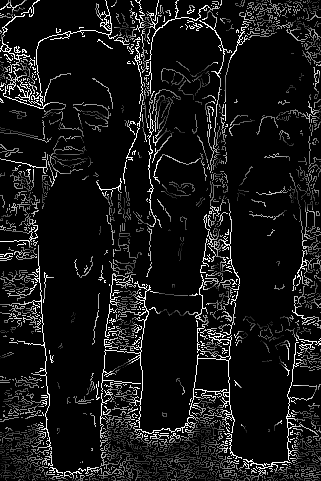


Edge detection by oriented filters followed by applying NMS using the binary map



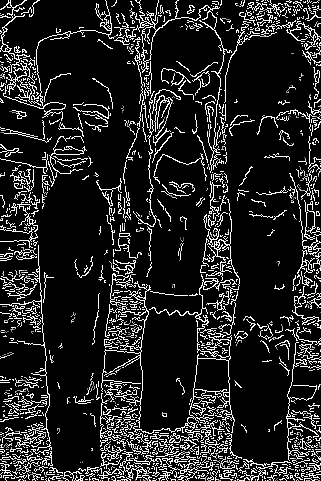

In [ ]:
im = read_image('/content/edge_detection_inputs/101085.jpg')

sigma = 6

oriented, oriented_filters = edgeOrientedFilters(im, sigma)
DoG = edgeGradient(im, sigma)

print("\nEdge detection by DoG followed by applying NMS using the binary map\n")
cv2_imshow(DoG**0.7)

print("\nEdge detection by oriented filters followed by applying NMS using the binary map\n")
cv2_imshow(oriented**0.7)


Edge detection by DoG followed by applying NMS using the binary map



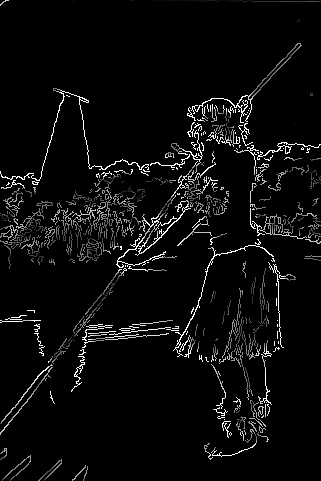


Edge detection by oriented filters followed by applying NMS using the binary map



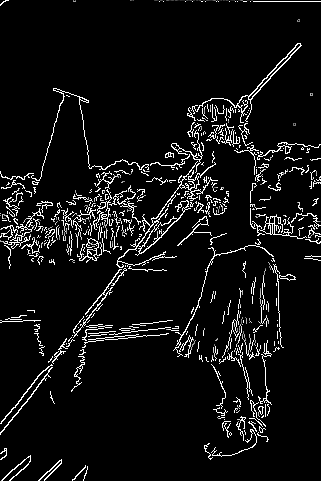

In [ ]:
im = read_image('/content/edge_detection_inputs/101087.jpg')

sigma = 6

oriented, oriented_filters = edgeOrientedFilters(im, sigma)
DoG = edgeGradient(im, sigma)

print("\nEdge detection by DoG followed by applying NMS using the binary map\n")
cv2_imshow(DoG**0.7)

print("\nEdge detection by oriented filters followed by applying NMS using the binary map\n")
cv2_imshow(oriented**0.7)


Edge detection by DoG followed by applying NMS using the binary map



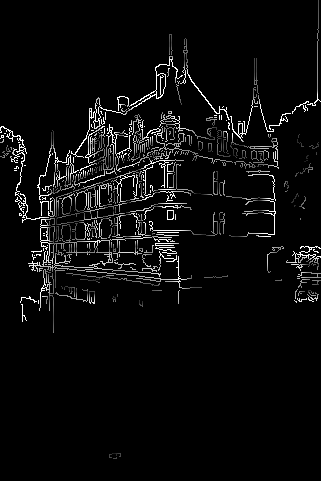


Edge detection by oriented filters followed by applying NMS using the binary map



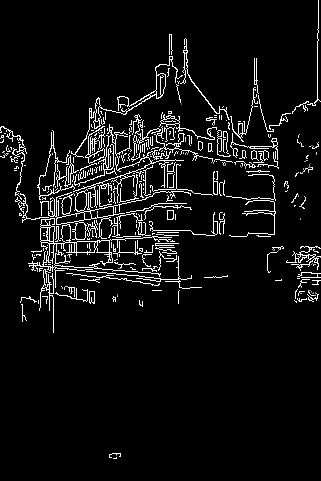

In [ ]:
im = read_image('/content/edge_detection_inputs/102061.jpg')

sigma = 6

oriented, oriented_filters = edgeOrientedFilters(im, sigma)
DoG = edgeGradient(im, sigma)

print("\nEdge detection by DoG followed by applying NMS using the binary map\n")
cv2_imshow(DoG**0.7)

print("\nEdge detection by oriented filters followed by applying NMS using the binary map\n")
cv2_imshow(oriented**0.7)


Edge detection by DoG followed by applying NMS using the binary map



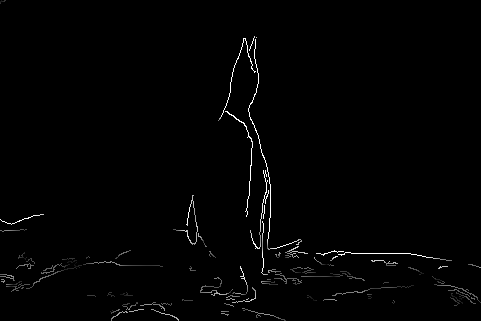


Edge detection by oriented filters followed by applying NMS using the binary map



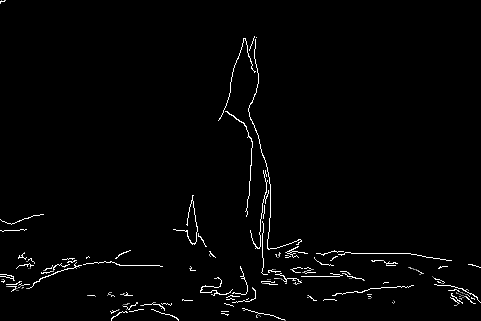

In [ ]:
im = read_image('/content/edge_detection_inputs/106024.jpg')

sigma = 6

oriented, oriented_filters = edgeOrientedFilters(im, sigma)
DoG = edgeGradient(im, sigma)

print("\nEdge detection by DoG followed by applying NMS using the binary map\n")
cv2_imshow(DoG**0.7)

print("\nEdge detection by oriented filters followed by applying NMS using the binary map\n")
cv2_imshow(oriented**0.7)


Edge detection by DoG followed by applying NMS using the binary map



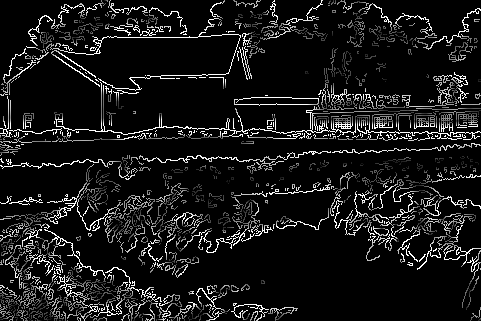


Edge detection by oriented filters followed by applying NMS using the binary map



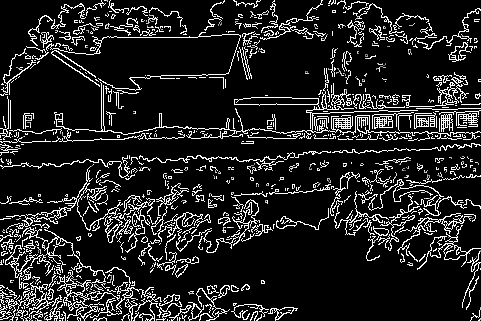

In [ ]:
im = read_image('/content/edge_detection_inputs/97033.jpg')

sigma = 6

oriented, oriented_filters = edgeOrientedFilters(im, sigma)
DoG = edgeGradient(im, sigma)

print("\nEdge detection by DoG followed by applying NMS using the binary map\n")
cv2_imshow(DoG**0.7)

print("\nEdge detection by oriented filters followed by applying NMS using the binary map\n")
cv2_imshow(oriented**0.7)

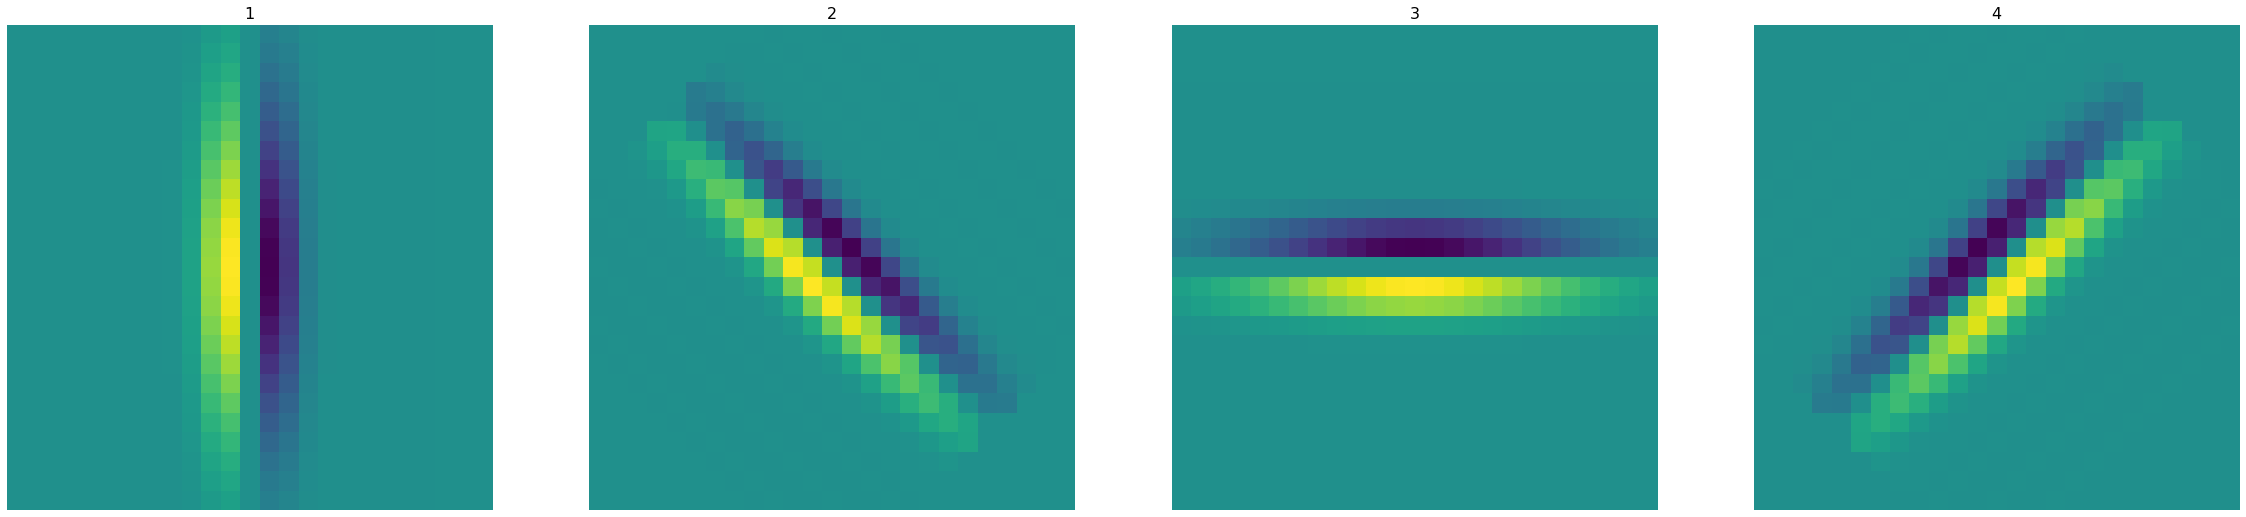

In [ ]:
fig = plt.figure(figsize=(40, 10))
rows = 1
columns = 4

for i in range(len(oriented_filters)):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(oriented_filters[i])
  plt.axis('off')
  plt.title(str(i+1),fontsize = 16)


# Write-up

Description of any design choices and parameters: A sigma of 6 and hence a gaussian filter size of 25 was chosen in both DoG and Oriented Filter based edge detection so that the high frequency components don't introduce any unncessary edges. Maximum threshold and minimum threshold was adjusted to 300 and 150 respectively so as to ensure that all the major edges appeared in the binary map used for NMS. An elongated Gaussian kernel of y_sigma = 6 and x_sigma = 1 was chosen to build the different oriented filters. 4 different filters of gradient orientations along 0 degrees, 45 degrees, 90 degrees and 135 degrees were chosen. The elongated Gaussian was cross-correlated with a x-gradient kernel, followed by rotations of 45, 90 and 135 degrees to get the bank of oriented filters.

Quality of results and possible ways of improvement: The results from both the detectors in every case have been scaled by raising to the power of 0.7 before visualization. The base Gaussian filter size is also consistent with both the filters for fair comparison. We can see that most of the slanted boundaries in the edge detections from the simple DoG based edge detector are rather light in color, which means that the edge detector is showing a weak response in these regions. Whereas, when the edge detection is done using the oriented filters method, we can show high response in all regions (Solid white lines), even in the regions of slanted lines. This is because of the oriented filters' ability to capture gradients better even with slanted edges. 

The results above use CV2.Canny, which does gradient magnitude and orientation computation with simple Sobel filters. The result could've been improved by using a non-max supression utilizing the orientations output from the the oriented filter function, which use a weighted angle approach to determine the direction of gradient orientation. The edge detections in the case of oriented filter method can be further improved by not just taking the maximum response from one filter out of the bank of filters, but instead having a threshold to accomodate responses from multiple gradient filters at once. 